Generated samples:
[[ 6.3869834e-01  8.2009476e-01  3.5336354e-01 -1.0572432e+00
   2.1038783e-01]
 [-7.6191574e-01  3.1989622e-01  1.2598137e+00  5.0566471e-01
  -1.0319074e+00]
 [-1.3667154e-01  1.7054586e-01  1.1970059e-01 -4.4006690e-01
  -4.9825430e-01]
 [-8.9312452e-01 -5.1784164e-01 -7.2631007e-01 -1.2116599e+00
   9.4013929e-01]
 [-1.3647888e+00 -1.2093653e-01  2.2593313e-01 -1.2984551e+00
   3.5025634e-02]
 [-4.5522898e-02  1.1910174e+00 -6.9330746e-01  1.4646931e+00
   9.5202976e-01]
 [-9.6173257e-01 -1.3825331e+00  1.2549495e+00 -6.9079947e-01
   8.8159204e-01]
 [-1.1997858e+00  2.3198485e+00  3.2901800e-01 -5.5070686e-01
   9.8761284e-01]
 [-1.3315791e+00 -9.8853689e-01  7.9408187e-01 -4.2259246e-01
  -6.0659671e-01]
 [ 9.8102927e-01  1.0593059e+00  1.6634908e+00  3.7268808e-01
  -1.4362633e-03]]


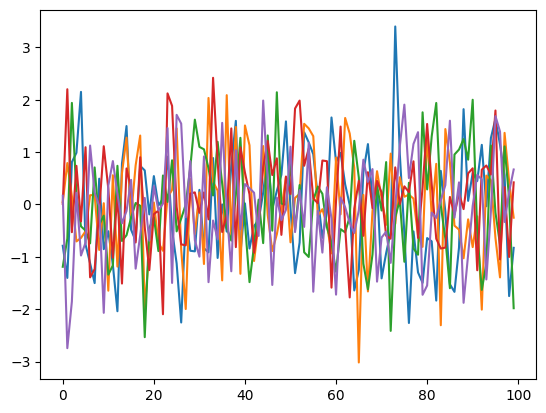

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class GRBM(nn.Module):
    def __init__(self, num_visible, num_hidden, num_output):
        super(GRBM, self).__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.num_output = num_output

        # Initialize parameters
        self.weights = nn.Parameter(torch.randn(num_visible, num_hidden) * 0.1)
        self.visible_bias = nn.Parameter(torch.zeros(num_visible))
        self.hidden_bias = nn.Parameter(torch.zeros(num_hidden))
        self.output_layer = nn.Linear(num_hidden, num_output)

    def forward(self, visible_probs):
        hidden_probs = torch.sigmoid(torch.mm(visible_probs, self.weights) + self.hidden_bias)
        hidden_states = (hidden_probs > torch.rand_like(hidden_probs)).float()
        output = self.output_layer(hidden_probs)
        return output, hidden_states

    def contrastive_divergence(self, visible_data, learning_rate=0.1, k=1):
        num_samples = visible_data.shape[0]

        # Positive phase
        positive_hidden_probs, positive_hidden_states = self.forward(visible_data)

        # Negative phase
        for _ in range(k):
            negative_visible_probs, negative_visible_states = self.sample_visible_given_hidden(positive_hidden_states)
            _, negative_hidden_states = self.forward(negative_visible_probs)

        # Update parameters
        self.weights.data += learning_rate * (
            torch.mm(visible_data.t(), positive_hidden_probs) - torch.mm(negative_visible_states.t(), negative_hidden_states)
        ) / num_samples

        self.visible_bias.data += learning_rate * torch.mean(visible_data - negative_visible_states, dim=0)
        self.hidden_bias.data += learning_rate * torch.mean(positive_hidden_probs - negative_hidden_states, dim=0)

        # Add a dense layer after contrastive divergence
        dense_output = self.output_layer(positive_hidden_probs)

        return dense_output

    def train_rbm(self, data, epochs=10, learning_rate=0.1, k=1):
        for epoch in range(epochs):
            np.random.shuffle(data)
            visible_data = torch.from_numpy(data).float()
            _ = self.contrastive_divergence(visible_data, learning_rate, k)

    def sample_visible_given_hidden(self, hidden_states):
        visible_probs = torch.mm(hidden_states, self.weights.t()) + self.visible_bias
        visible_states = visible_probs + torch.randn_like(visible_probs)
        return visible_probs, visible_states

# Example usage
num_visible_units = 5
num_hidden_units = 3
num_output_units = 3
rbm = GRBM(num_visible_units, num_hidden_units, num_output_units)

# Assuming you have some training data (replace this with your actual data)
training_data = np.random.randn(100, num_visible_units)

# Training the RBM
rbm.train_rbm(training_data, epochs=50)

# Generating samples
generated_samples = rbm.sample_visible_given_hidden(torch.rand(10, num_hidden_units))[1].detach().numpy()

print("Generated samples:")
print(generated_samples)

plt.plot(training_data)